In [3]:
import csv
import numpy as np
import pandas as pd
import math
import seaborn as sb
from matplotlib import pyplot as plt
import trianglesolver as ts
from math import pi

X


In [4]:
# d = previous state distance to target
# b = previous state bearing to target
# d_meas = new measurement of distance to target
# b_meas = new measurement of bearing to target

def kalman_update(d, b, d_meas, d_bear, K):
    d_prime = K * d + (1-K) * d_meas
    b_prime = K * b + (1-K) * d_bear
    return (d_prime, b_prime)

In [ ]:
def rerange(x):
    if (x >math.pi/2):
        x = x-math.pi
    return x

In [43]:
# a = previous state distance to target
# B = previous state bearing to target
# c = amount moved forward
# Returns (b = new distance to target, A=new bearing to target)
# Note that if no motion, bearing and distance dont change

def kalman_predict(a, B, c):
    #print(f"KP {a} {B} {c}")
    if (c == 0):
        #print("c == 0")
        return(a, B)
    elif (B == pi):
        print("B == pi")
        return(a, B)
    elif (B > pi):
        B_prime = (2*pi - B)
        print (f"B > pi: {B} {B_prime}")
        (tsa,tsb,tsc,tsA,tsB,tsC) = ts.solve(a=a, B=B_prime, c=c)
        return (tsb, 2*pi - tsA)
    else:
        (tsa,tsb,tsc,tsA,tsB,tsC) = ts.solve(a=a, B=B, c=c)
        return(tsb, tsA)
    
def another_kalman_predict(a, B, c):
    print(f"KP {a} {B} {c}")
    if (c == 0):
        return(a, B)
    else:
        b = law_of_cosines_b(a, c, B)
        A = law_of_sines_A(a,B,b)
    return (b, A)

def dumb_kalman_predict(d, b, m):
    d_prime = d
    b_prime = b
    return d_prime, b_prime

In [30]:
# Edges are named after the opposite angle
def law_of_sines_A_actual(a, B, b):
    """ returns angle A given sides a,b and angle B"""
    temp = (a * math.sin(B)) / b
    if (temp < -1 or temp > 1.0):
        print("losA error", temp)
    return (math.asin((a * math.sin(B)) / b))

def law_of_sines_A(a, B, b):
    Btype = 'acute' if B < pi/2 else 'obtuse'
    a, b, c, A, B, C = ts.solve(a=a, B=B, b=b, ssa_flag=Btype)
    print (A)
    return A

In [31]:
# Capital letter B is an angle. Small a, b and c are edges. 
# a is the edge across from A (I think that covers it.)
def law_of_cosines_B_actual(a, b, c):
    """ returns angle B given sides a,b and c"""
    temp = (b**2 - a**2 - c**2)/(-2.0 * a * c)
    if (temp < -1 or temp > 1.0):
        print("loc error")
    return math.acos((b**2 - a**2 - c**2)/(-2.0 * a * c))

def law_of_cosines_B(a, b, c):
    a, b, c, A, B, C = ts.solve(a=a, b=b, c=c)
    return B

In [32]:
# Capital letter B is an angle. Small a, b and c are edges. 
# a is the edge across from A (I think that covers it.)
def law_of_cosines_b_actual(a, c, B):
    """ returns side b given sides a,c and angle B"""
    return(math.sqrt(a**2 + c**2 - 2*a*c*math.cos(B)))

def law_of_cosines_b(a, c, B):
    Btype = 'acute' if B < pi/2 else 'obtuse'
    if B==0 or a == 0 or c == 0:
        print(a, B, c)
    if B >= pi:
        print(f"B {B}")

    a, b, c, A, B, C = ts.solve(a=a, B=B, c=c, ssa_flag=Btype)
    return(b)

In [33]:
# Capital letter A is an angle. Small a, b and c are edges. 
# a is the edge across from A (I think that covers it.)
def law_of_cosines_A_actual(a, b, c):
    """ returns angle A given sides a,b and angle B"""
    return math.acos((-(a*a) + b*b + c*c) / (2 * b * c))

In [34]:
# elapsed,g_forward_cmd,g_turn_cmd,g_shortest_bearing,g_shortest
df=pd.read_csv('motion4.csv', sep=',')

In [35]:
def test_harnass(K):
    state_dist = 0.8
    state_bear = math.radians(80)
    for index, row in df.iterrows():
        meas_dist = row['g_shortest']
        meas_bear = math.radians(row['g_shortest_bearing'])
        control_motion = row['g_forward_cmd'] * row['elapsed']
        temp_state_dist, temp_state_bear = kalman_predict(state_dist, state_bear, control_motion)
        pure_state_dist, pure_state_bear = kalman_predict(meas_dist, meas_bear, control_motion)
        state_dist, state_bear = kalman_update(temp_state_dist, temp_state_bear, meas_dist, meas_bear, K)
        df.loc[df.index[index], 'm'] = control_motion    
        df.loc[df.index[index], 'meas_dist'] = meas_dist
        df.loc[df.index[index], 'pure_state_dist'] = pure_state_dist    
        df.loc[df.index[index], 'temp_state_dist'] = temp_state_dist
        df.loc[df.index[index], 'state_dist'] = state_dist
        df.loc[df.index[index], 'meas_bear'] = math.degrees(meas_bear)
        df.loc[df.index[index], 'pure_state_bear'] = math.degrees(pure_state_bear)
        df.loc[df.index[index], 'state_bear'] = math.degrees(state_bear)
        df.loc[df.index[index], 'temp_state_bear'] = math.degrees(temp_state_bear)
        df.loc[df.index[index], 'K'] = K
    return df

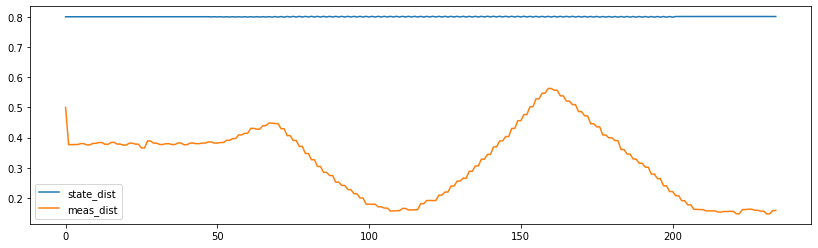

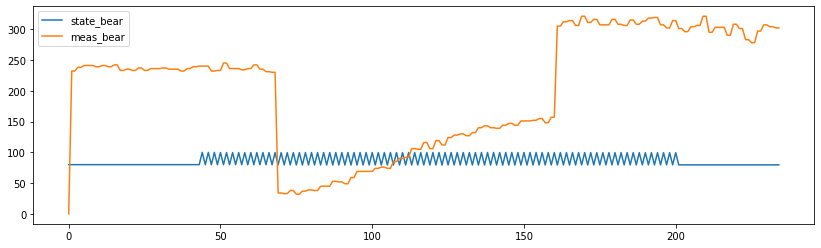

In [36]:
df = test_harnass(1.0)
df.plot(y=['state_dist', 'meas_dist'], figsize=[14,4])
df.plot(y=['state_bear', 'meas_bear'], figsize=[14,4])

In [44]:
# Test various trig functions
from math import pi
import trianglesolver as ts
ts.solve(a=1, b=1, c=1)

df1 = pd.DataFrame(columns = ["b_index", "B", "l", "d", "d_prime", "b_prime"])
start = 1
end = 360
for b_index in range (start, end):
    B = math.radians(b_index)
    l = 1
    d = 1
    d_prime, b_prime = kalman_predict(d, B, l)
    df1 = df1.append([{"B": math.degrees(B), 
                     "l":l,
                     "d": d, 
                     "d_prime": d_prime, 
                     "b_prime": math.degrees(b_prime), 
                     "b_index": b_index}])
df1 = df1.set_index("b_index")    

B == pi
B > pi: 3.1590459461097367 3.1241393610698496
B > pi: 3.1764992386296798 3.1066860685499065
B > pi: 3.193952531149623 3.0892327760299634
B > pi: 3.2114058236695664 3.07177948351002
B > pi: 3.2288591161895095 3.0543261909900767
B > pi: 3.246312408709453 3.036872898470133
B > pi: 3.263765701229396 3.01941960595019
B > pi: 3.2812189937493397 3.0019663134302466
B > pi: 3.2986722862692828 2.9845130209103035
B > pi: 3.3161255787892263 2.96705972839036
B > pi: 3.3335788713091694 2.949606435870417
B > pi: 3.351032163829113 2.9321531433504733
B > pi: 3.368485456349056 2.91469985083053
B > pi: 3.385938748868999 2.897246558310587
B > pi: 3.4033920413889427 2.8797932657906435
B > pi: 3.420845333908886 2.8623399732707004
B > pi: 3.4382986264288293 2.844886680750757
B > pi: 3.4557519189487724 2.827433388230814
B > pi: 3.473205211468716 2.8099800957108703
B > pi: 3.490658503988659 2.792526803190927
B > pi: 3.5081117965086026 2.7750735106709836
B > pi: 3.5255650890285457 2.7576202181510405
B >

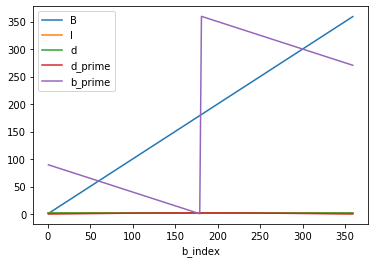

In [45]:
df1.plot()